# STEP B

In [4]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

def read_image_and_compute_keypoints(object_imgs, scene_imgs, detector):
    imgs_dict = {}

    for name_img in object_imgs:
        img_load = cv2.imread('models/' + name_img + '.jpg', cv2.IMREAD_GRAYSCALE)
        
        """
        # Enlever le centre de l'image
        row = int(img_load.shape[0]/2)
        col = int(img_load.shape[1]/2)
        pour = 0.5
        new_color = 255 # White
        img_load[int(row - row*pour) : int(row + row*pour), int(col - col*pour): int(col + col*pour)] = new_color
        #
        """

        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    for name_img in scene_imgs:
        img_load = cv2.imread('scenes/' + name_img + '.png', cv2.IMREAD_GRAYSCALE)
        kp, des = detector.detectAndCompute(img_load, None)
        imgs_dict[name_img] = {'kp': kp, 'des': des, 'shape': img_load.shape}

    return imgs_dict

def matching_and_localize_objects_in_scene(imgs_dict, name_scene_img, ratio_test=0.45):
    all_scene_corners = {}
    all_good ={}
    for name in object_imgs:
        object_des, object_kp = imgs_dict[name]['des'], imgs_dict[name]['kp']
        scene_des, scene_kp = imgs_dict[name_scene_img]['des'], imgs_dict[name_scene_img]['kp']
        
        #-- matching
        matches = matcher.knnMatch(object_des, scene_des, k=2)
    
        #-- store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < ratio_test*n.distance:
                good.append(m)
                
        if len(good) > 30:        
            #-- Get the keypoints from the good matches
            object_good_kp = np.float32([ object_kp[m.queryIdx].pt for m in good ])
            scene_good_kp = np.float32([ scene_kp[m.trainIdx].pt for m in good ])   


            #-- Get the corners of object
            h,w = imgs_dict[name]['shape'][0:2]
            object_corners = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            #-- Get the homography of object/scene
            H, _ =  cv2.findHomography(object_good_kp, scene_good_kp, cv2.RANSAC, 5.0)

            #-- Get the corners of object in scene
            scene_corners = cv2.perspectiveTransform(object_corners, H)


            all_scene_corners[name] = scene_corners
            all_good[name] = good
        
    return all_scene_corners, all_good

def check_best_color_matches(all_scene_corners, name_scene_img):
    
    scene_img_bgr = cv2.imread('scenes/' + name_scene_img + '.png')
    best_all_scene_corners = {}
    
    for name in all_scene_corners.keys():

        x_min = max(int(np.min(all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(all_scene_corners[name], axis=0)[0][1])
        
        object_img_bgr = cv2.imread('models/' + name + '.jpg')
        
        object_img_mean_color = object_img_bgr.mean(axis=0).mean(axis=0)
        object_in_scene_img = scene_img_bgr[y_min:y_max,x_min:x_max]
        object_in_scene_img_mean_color = object_in_scene_img.mean(axis=0).mean(axis=0)   
        color_diff = np.sqrt(np.sum([value ** 2 for value in abs(object_img_mean_color - object_in_scene_img_mean_color)]))
        
        #color_diff = (np.sum([value **2 for value in (object_img_mean_color - object_in_scene_img_mean_color)]))/4
        
        if color_diff < 60:
            best_all_scene_corners[name] = all_scene_corners[name]
        
    return best_all_scene_corners

def drawn_object_lines_in_scene(img_scene, best_all_scene_corners):
    for name in best_all_scene_corners.keys():
        scene_corners = best_all_scene_corners[name]
        img_scene = cv2.polylines(img_scene, [np.int32(scene_corners)], 
                                  isClosed=True, color=(0,255,0), thickness=5)
    return img_scene

def print_object_found(best_all_scene_corners):
    for name in best_all_scene_corners.keys():  
        x_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][0]), 0)
        y_min = max(int(np.min(best_all_scene_corners[name], axis=0)[0][1]), 0)
        x_max = int(np.max(best_all_scene_corners[name], axis=0)[0][0])
        y_max = int(np.max(best_all_scene_corners[name], axis=0)[0][1])
        
        print('Product {} - {} instance/s found:'.format(name, 1))
        print('\tInstance {} position: {}, width: {}px, height: {}px'.format(1, (x_min, y_min), (x_max-x_min), (y_max-y_min)))
    
    print('_' * 80 + '\n')

def stepA():
    
    detector = cv2.SIFT_create()
    FLANN_INDEX_KDTREE = 1

        # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

        # Defining search params.
        # checks=50 specifies the number of times the trees in the index should be recursively traversed.
        # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

        # Initializing matcher
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    #matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    
    imgs_dict = read_image_and_compute_keypoints(object_imgs, scene_imgs, detector)
    
    
    for scene_name in scene_imgs:
        
        all_scene_corners, all_good= matching_and_localize_objects_in_scene(imgs_dict, scene_name)
        
        best_all_scene_corners = check_best_color_matches(all_scene_corners , scene_name)
        
        
        img_scene_rgb = cv2.cvtColor(cv2.imread('scenes/' + scene_name + '.png'), cv2.COLOR_BGR2RGB)
        img_scene_rgb = drawn_object_lines_in_scene(img_scene_rgb, best_all_scene_corners)

        
        print('Scene {} :'.format(scene_name))
        plt.imshow(img_scene_rgb)
        plt.show()
        print_object_found(best_all_scene_corners)

In [5]:
#-- bank of image step B
object_imgs = ['0', '1', '11', '19', '24', '25', '26']
#object_imgs = ['0', '11']
scene_imgs = ['m1', 'm2', 'm3', 'm4', 'm5']

Scene m1 :


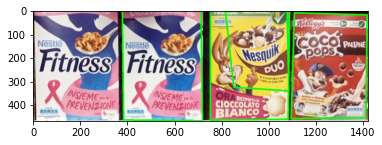

Product 0 - 1 instance/s found:
	Instance 1 position: (818, 0), width: 269px, height: 339px
Product 24 - 1 instance/s found:
	Instance 1 position: (379, 0), width: 341px, height: 466px
Product 25 - 1 instance/s found:
	Instance 1 position: (1097, 7), width: 323px, height: 449px
Product 26 - 1 instance/s found:
	Instance 1 position: (754, 0), width: 337px, height: 463px
________________________________________________________________________________

Scene m2 :


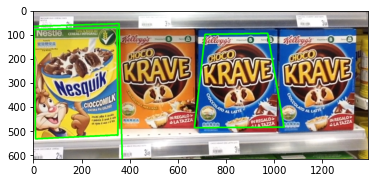

Product 0 - 1 instance/s found:
	Instance 1 position: (4, 71), width: 348px, height: 461px
Product 1 - 1 instance/s found:
	Instance 1 position: (670, 96), width: 372px, height: 390px
Product 26 - 1 instance/s found:
	Instance 1 position: (0, 56), width: 371px, height: 645px
________________________________________________________________________________

Scene m3 :


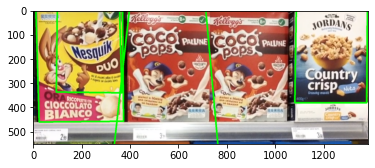

Product 0 - 1 instance/s found:
	Instance 1 position: (96, 0), width: 271px, height: 340px
Product 19 - 1 instance/s found:
	Instance 1 position: (1082, 0), width: 300px, height: 381px
Product 25 - 1 instance/s found:
	Instance 1 position: (333, 0), width: 431px, height: 577px
Product 26 - 1 instance/s found:
	Instance 1 position: (10, 0), width: 364px, height: 460px
________________________________________________________________________________

Scene m4 :


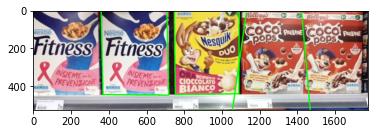

Product 24 - 1 instance/s found:
	Instance 1 position: (359, 0), width: 360px, height: 447px
Product 25 - 1 instance/s found:
	Instance 1 position: (1053, 0), width: 421px, height: 578px
Product 26 - 1 instance/s found:
	Instance 1 position: (748, 0), width: 345px, height: 444px
________________________________________________________________________________

Scene m5 :


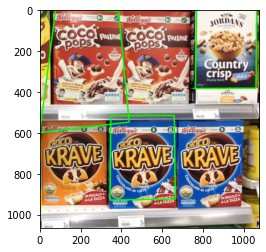

Product 1 - 1 instance/s found:
	Instance 1 position: (342, 515), width: 318px, height: 413px
Product 19 - 1 instance/s found:
	Instance 1 position: (758, 0), width: 299px, height: 383px
Product 25 - 1 instance/s found:
	Instance 1 position: (0, 0), width: 435px, height: 599px
________________________________________________________________________________



In [6]:
stepA()